In [243]:
import pandas as pd 
import wandb
from typing import Any

In [244]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [245]:
sns.set_style('ticks')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})


In [272]:
api = wandb.Api(api_key='0397e0196c2ed27234ec92d433cbe73fcfc72db1')

# Project is specified by <entity/project-name>
runs = api.runs(
    "tensor-programs-v-reproduction/tensor-reprogram",
    filters={"State": "finished"}
)

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k, v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

runs_df.to_csv("project.csv")

In [273]:
def flatten_dict(d: dict[str, Any], parent_key: str = '', sep: str = '.'):
    """
    A recursive function to flatten a nested dictionary into a single-level dictionary.

    Example:
        >>> flatten_dict({'a': 1, 'b': {'c': 2, 'd': 3}}, parent_key='parentkey', sep='|')
        {'parentkey|a': 1, 'parentkey|b|c': 2, 'parentkey|b|d': 3}
    """
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)


def flatten_dataframe(df: pd.DataFrame, columns: list[str]):
    """
    A function to flatten the nested dictionaries in the given dataframe.

    Args:
        df: The dataframe to flatten.
        columns: The columns with dictionary entries to flatten.
    """
    flat_data = []
    for i, row in df.iterrows():
        # Preserve the non-dictionary columns
        non_dict_cols = {col: row[col] for col in df.columns if col not in columns}
        # Flatten the specified dictionary columns
        dict_cols = {}
        for col in columns:
            dict_cols.update(flatten_dict(row[col], parent_key=col, sep='.'))
        # Combine the non-dictionary and dictionary columns and add the row name
        flat_data.append({'name': row['name'], **non_dict_cols, **dict_cols})

    return pd.DataFrame(flat_data)


In [274]:
runs_df = flatten_dataframe(runs_df, columns=['config', 'summary'])
runs_df.head()

,name,config.mlp_config.depth,config.mlp_config.width,config.mlp_config.add_bias,config.mlp_config.paper_init,config.mlp_config.hidden_sizes,config.num_epochs,config.data_loader.bptt,config.data_loader.pin_memory,config.data_loader.num_workers,...,summary.train.batch_loss,summary._timestamp,summary.train.loss,summary.train.accuracy,summary.train.batch_accuracy,summary._wandb.runtime,summary._runtime,summary.test.loss,summary.valid.loss,summary.valid.accuracy
0,youthful-sun-1368,NaN,NaN,True,False,"[4096, 4096]",20,35,False,4,...,1.970696,1.678902e+09,2.042013,0.29934,0.3750,285,278.683658,2.037591,NaN,NaN
1,lunar-salad-1367,NaN,NaN,True,False,"[4096, 4096]",20,35,False,4,...,0.90847,1.678902e+09,0.840559,0.72132,0.8125,245,238.593911,1.325332,NaN,NaN
2,exalted-violet-1366,NaN,NaN,True,False,"[2048, 2048]",20,35,False,4,...,2.070915,1.678902e+09,2.086273,0.27752,0.1250,354,355.066382,2.083082,NaN,NaN
3,fearless-universe-1365,NaN,NaN,True,False,"[4096, 4096]",20,35,False,4,...,1.715056,1.678902e+09,1.748479,0.39102,0.3125,216,224.907889,1.748839,NaN,NaN
4,solar-durian-1364,NaN,NaN,True,False,"[2048, 2048]",20,35,False,4,...,0.704088,1.678902e+09,0.615383,0.79488,0.8125,303,299.050955,1.524206,NaN,NaN


## MLP Experiment

In [280]:
# Filter to only include runs with MLP architecture_type and CIFAR10 dataset
mlp_runs_df = runs_df[
    (runs_df['config.architecture_type'] == 'ArchitectureType.MLP')
    & (runs_df['config.dataset_type'] == 'DatasetType.CIFAR10')
    & (runs_df['config.use_mu_param'] == True)
    & runs_df['config.mlp_config.hidden_sizes']
]
mlp_runs_df = mlp_runs_df[
    # Only include runs with 2 hidden layers
    (mlp_runs_df['config.mlp_config.hidden_sizes'].apply(lambda l: len(l) == 2))
]
# Add a "width" column to the dataframe. This is the first hidden layer size from the "config.mlp_config.hidden_sizes" column.
mlp_runs_df['width'] = mlp_runs_df['config.mlp_config.hidden_sizes'].apply(lambda x: x[0])
mlp_runs_df['config.optimization.lr_log2'] = np.log2(mlp_runs_df['config.optimization.lr'])
# Check that all hidden sizes match the width column
assert all(mlp_runs_df['config.mlp_config.hidden_sizes'].apply(lambda x: all([y == x[0] for y in x])))

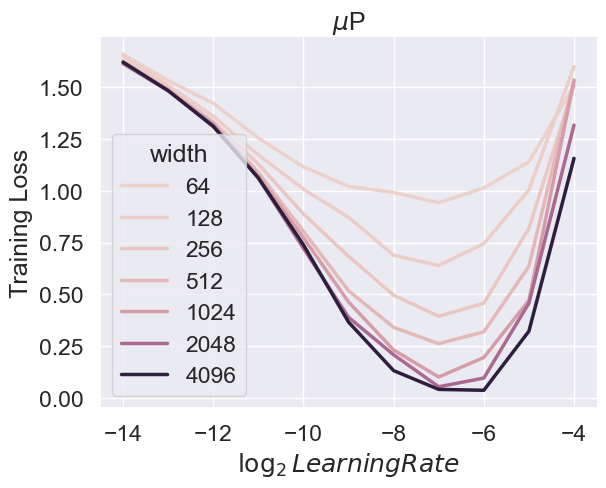

In [282]:
ax = sns.lineplot(data=mlp_runs_df, x='config.optimization.lr_log2', y='summary.train.loss', hue='width', legend="full")
# ax.set_xscale('log')
sns.set_style('darkgrid')
ax.set(xlabel="$\log_2LearningRate$", ylabel="Training Loss", title='$\mu$P')
sns.despine(ax=ax, offset=3)
fig = ax.get_figure()
fig.savefig("mlp_mup_train.png", bbox_inches='tight')

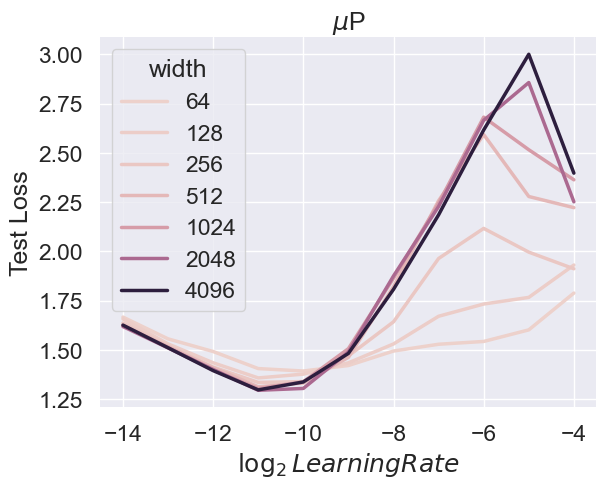

In [283]:
# ax = sns.lineplot(data=mlp_runs_df, x='config.optimization.lr', y='summary.test.loss', hue='width')
# ax.set_xscale('log')
ax = sns.lineplot(data=mlp_runs_df, x='config.optimization.lr_log2', y='summary.test.loss', hue='width', legend="full")
# ax.set_xscale('log')
sns.set_style('darkgrid')
ax.set(xlabel="$\log_2LearningRate$", ylabel="Test Loss", title='$\mu$P')
# ax.set_xlim(mlp_runs_df['config.optimization.lr'].min(), mlp_runs_df['config.optimization.lr'].max())
sns.despine(ax=ax, offset=3)
fig = ax.get_figure()
fig.savefig("mlp_mup_test.png", bbox_inches='tight')

### MLP with SP

In [290]:
# Filter to only include runs with MLP architecture_type and CIFAR10 dataset
mlp_runs_df = runs_df[
    (runs_df['config.architecture_type'] == 'ArchitectureType.MLP')
    & (runs_df['config.dataset_type'] == 'DatasetType.CIFAR10')
    & (runs_df['config.use_mu_param'] == False)
    & (runs_df['config.mlp_config.add_bias'] == False)
    & runs_df['config.mlp_config.hidden_sizes']
]
mlp_runs_df = mlp_runs_df[
    # Only include runs with 2 hidden layers
    (mlp_runs_df['config.mlp_config.hidden_sizes'].apply(lambda l: len(l) == 2))
]
mlp_runs_df = mlp_runs_df[mlp_runs_df['summary.train.loss'] != 'NaN']
# Add a "width" column to the dataframe. This is the first hidden layer size from the "config.mlp_config.hidden_sizes" column.
mlp_runs_df['width'] = mlp_runs_df['config.mlp_config.hidden_sizes'].apply(lambda x: x[0])
mlp_runs_df['config.optimization.lr_log2'] = np.log2(mlp_runs_df['config.optimization.lr'])
# Check that all hidden sizes match the width column
assert all(mlp_runs_df['config.mlp_config.hidden_sizes'].apply(lambda x: all([y == x[0] for y in x])))

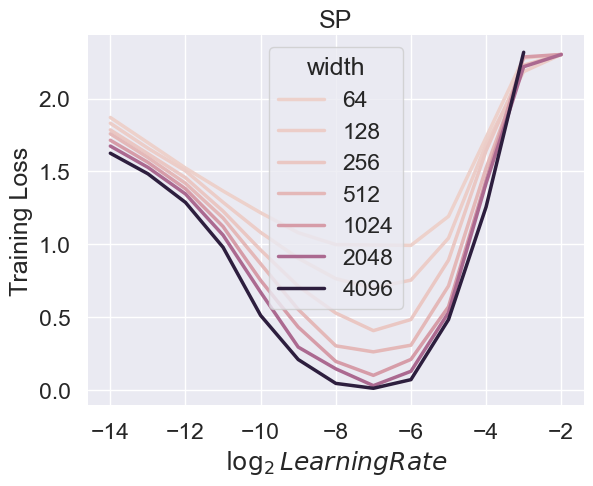

In [295]:
ax = sns.lineplot(data=mlp_runs_df, x='config.optimization.lr_log2', y='summary.train.loss', hue='width', legend="full")
# ax.set_xscale('log')
sns.set_style('darkgrid')
ax.set(xlabel="$\log_2LearningRate$", ylabel="Training Loss", title='SP')
# ax.set_xlim(mlp_runs_df['config.optimization.lr'].min(), mlp_runs_df['config.optimization.lr'].max())
sns.despine(ax=ax, offset=3)
fig = ax.get_figure()
fig.savefig("mlp_sp_train.png", bbox_inches='tight')

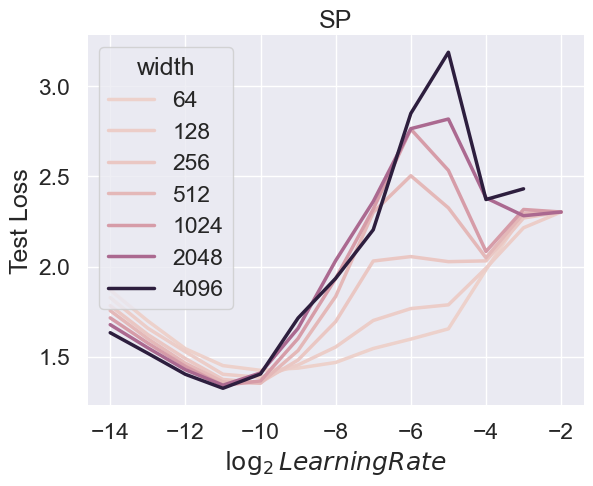

In [297]:
ax = sns.lineplot(data=mlp_runs_df, x='config.optimization.lr_log2', y='summary.test.loss', hue='width', legend="full")
# ax.set_xscale('log')
sns.set_style('darkgrid')
ax.set(xlabel="$\log_2LearningRate$", ylabel="Test Loss", title='SP')
# ax.set_xlim(mlp_runs_df['config.optimization.lr'].min(), mlp_runs_df['config.optimization.lr'].max())
sns.despine(ax=ax, offset=3)
fig = ax.get_figure()
fig.savefig("mlp_sp_test.png", bbox_inches='tight')

## Transformer WikiText Experiment

In [298]:
# Filter to only include runs with MLP architecture_type and CIFAR10 dataset
transformer_runs_df = runs_df[
    (runs_df['config.architecture_type'] == 'ArchitectureType.TRANSFORMER')
    & (runs_df['config.dataset_type'] == 'DatasetType.WIKITEXT')
    & (runs_df['config.use_mu_param'] == True)
]
transformer_runs_df['config.optimization.lr_log2'] = np.log2(transformer_runs_df['config.optimization.lr'])
# Add a "width" column to the dataframe.
# transformer_runs_df.loc[:, 'width'] = transformer_runs_df['config.transformer_config.d_model'].copy()

/var/folders/9j/4qxs2j5j5dx6jpw5pcwvvwpc0000gn/T/ipykernel_78529/3923453855.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformer_runs_df['config.optimization.lr_log2'] = np.log2(transformer_runs_df['config.optimization.lr'])


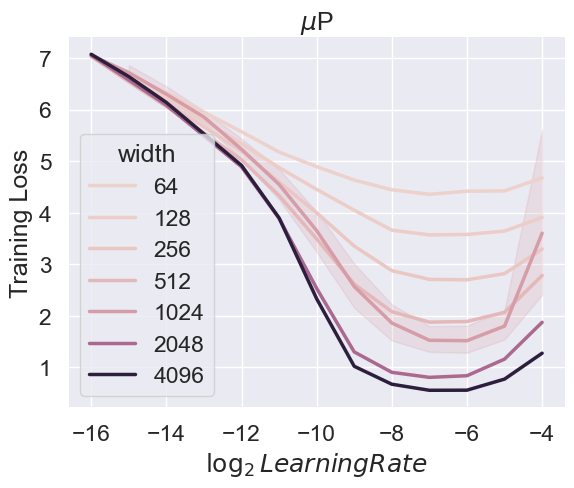

In [300]:
# Remove NaN results
runs_filtered = transformer_runs_df[transformer_runs_df['summary.train.loss'] != 'NaN']
runs_filtered = runs_filtered[runs_filtered['config.optimization.lr_log2'] >= -16]
ax = sns.lineplot(data=runs_filtered, x='config.optimization.lr_log2', y='summary.train.loss', hue='config.transformer_config.d_model', legend="full")
sns.set_style('darkgrid')
ax.legend_.set_title('width')
ax.set(xlabel="$\log_2LearningRate$", ylabel="Training Loss", title='$\mu$P')
sns.despine(ax=ax, offset=3)
fig = ax.get_figure()
fig.savefig("transformer_mup_train.png", bbox_inches='tight')

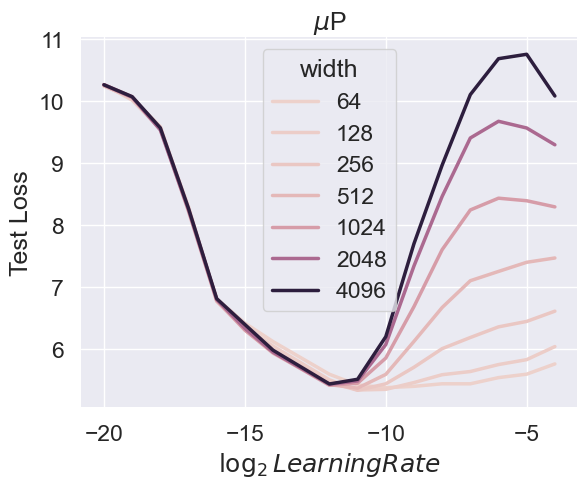

In [212]:
ax = sns.lineplot(data=runs_filtered, x='config.optimization.lr_log2', y='summary.test.loss', hue='config.transformer_config.d_model', legend="full")
sns.set_style('darkgrid')
ax.legend_.set_title('width')
ax.set(xlabel="$\log_2LearningRate$", ylabel="Test Loss", title='$\mu$P')
sns.despine(ax=ax, offset=3)
fig = ax.get_figure()
fig.savefig("transformer_mup_test.png", bbox_inches='tight')

### Transformer with SP

In [213]:
# Filter to only include runs with MLP architecture_type and CIFAR10 dataset
transformer_runs_df = runs_df[
    (runs_df['config.architecture_type'] == 'ArchitectureType.TRANSFORMER')
    & (runs_df['config.dataset_type'] == 'DatasetType.WIKITEXT')
    & (runs_df['config.use_mu_param'] == False)
]
# Add a "width" column to the dataframe.
# transformer_runs_df.loc[:, 'width'] = transformer_runs_df['config.transformer_config.d_model'].copy()

/var/folders/9j/4qxs2j5j5dx6jpw5pcwvvwpc0000gn/T/ipykernel_78529/3756611359.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformer_runs_df['config.optimization.lr_log2'] = np.log2(transformer_runs_df['config.optimization.lr'])


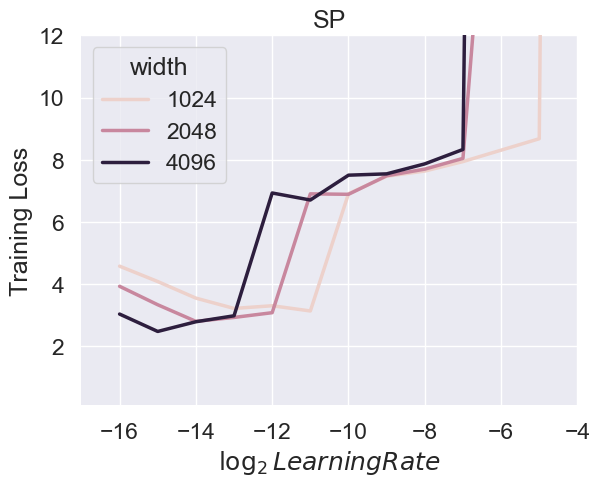

In [214]:
# Remove NaN results
transformer_runs_df['config.optimization.lr_log2'] = np.log2(transformer_runs_df['config.optimization.lr'])
runs_filtered = transformer_runs_df[transformer_runs_df['summary.train.loss'] != 'NaN']
# runs_filtered = runs_filtered[runs_filtered['config.transformer_config.d_model'] >= 1024]
ax = sns.lineplot(data=runs_filtered, x='config.optimization.lr_log2', y='summary.train.loss', hue='config.transformer_config.d_model', legend="full")
ax.set_ylim(1e-1, 12)
ax.set_xlim(-17, -4)
ax.legend_.set_title('width')
ax.set(xlabel="$\log_2LearningRate$", ylabel="Training Loss", title='SP')
sns.despine(ax=ax, offset=3)
fig = ax.get_figure()
fig.savefig("transformer_sp_train.png" ,bbox_inches='tight')

/var/folders/9j/4qxs2j5j5dx6jpw5pcwvvwpc0000gn/T/ipykernel_78529/2469093900.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformer_runs_df['config.optimization.lr_log2'] = np.log2(transformer_runs_df['config.optimization.lr'])


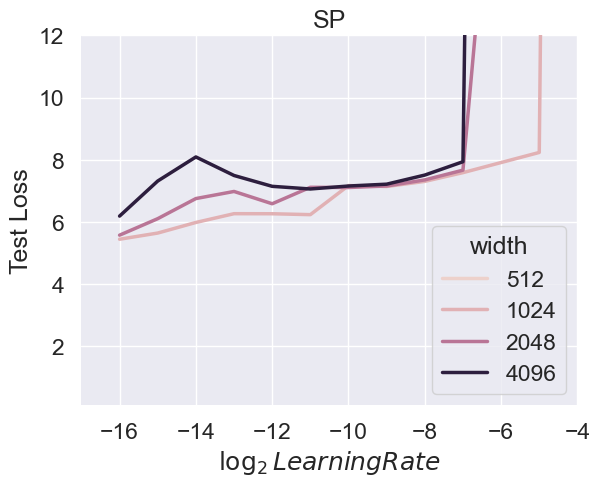

In [215]:
# Remove NaN results
transformer_runs_df['config.optimization.lr_log2'] = np.log2(transformer_runs_df['config.optimization.lr'])
runs_filtered = transformer_runs_df[transformer_runs_df['summary.train.loss'] != 'NaN']
ax = sns.lineplot(data=runs_filtered, x='config.optimization.lr_log2', y='summary.test.loss', hue='config.transformer_config.d_model', legend="full")
ax.set_ylim(1e-1, 12)
ax.set_xlim(-17, -4)
ax.legend_.set_title('width')
ax.set(xlabel="$\log_2LearningRate$", ylabel="Test Loss", title='SP')
sns.despine(ax=ax, offset=3)
fig = ax.get_figure()
fig.savefig("transformer_sp_test.png" ,bbox_inches='tight')

### Transformer with depth

In [237]:
# Filter to only include runs with MLP architecture_type and CIFAR10 dataset
transformer_runs_df = runs_df[
    (runs_df['config.architecture_type'] == 'ArchitectureType.TRANSFORMER')
    & (runs_df['config.dataset_type'] == 'DatasetType.WIKITEXT')
    & (runs_df['config.transformer_config.d_model'] == 1024)
    & (runs_df['config.use_mu_param'] == True)
]

/var/folders/9j/4qxs2j5j5dx6jpw5pcwvvwpc0000gn/T/ipykernel_78529/717312588.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformer_runs_df['config.optimization.lr_log2'] = np.log2(transformer_runs_df['config.optimization.lr'])


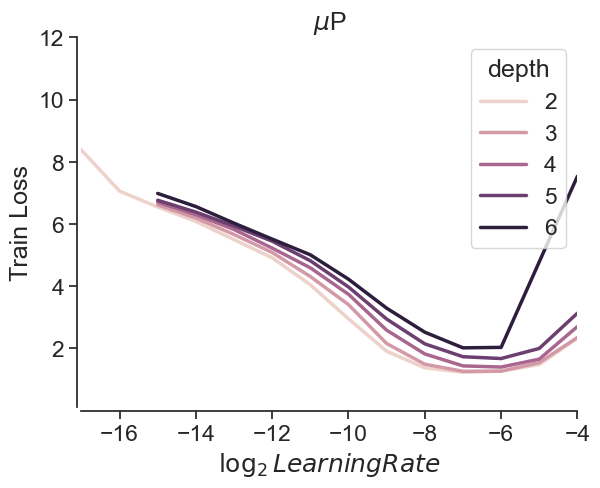

In [238]:
# Remove NaN results
transformer_runs_df['config.optimization.lr_log2'] = np.log2(transformer_runs_df['config.optimization.lr'])
runs_filtered = transformer_runs_df[transformer_runs_df['summary.train.loss'] != 'NaN']
ax = sns.lineplot(data=runs_filtered, x='config.optimization.lr_log2', y='summary.train.loss', hue='config.transformer_config.nlayers', legend="full")
ax.set_ylim(1e-1, 12)
ax.set_xlim(-17, -4)
ax.legend_.set_title('depth')
ax.set(xlabel="$\log_2LearningRate$", ylabel="Train Loss", title='$\mu$P')
sns.despine(ax=ax, offset=3)
fig = ax.get_figure()
fig.savefig("transformer_mup_train_depth.png" ,bbox_inches='tight')

In [239]:
# Filter to only include runs with MLP architecture_type and CIFAR10 dataset
transformer_runs_df = runs_df[
    (runs_df['config.architecture_type'] == 'ArchitectureType.TRANSFORMER')
    & (runs_df['config.dataset_type'] == 'DatasetType.WIKITEXT')
    & (runs_df['config.transformer_config.d_model'] == 1024)
    & (runs_df['config.use_mu_param'] == False)
]

/var/folders/9j/4qxs2j5j5dx6jpw5pcwvvwpc0000gn/T/ipykernel_78529/3950238396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformer_runs_df['config.optimization.lr_log2'] = np.log2(transformer_runs_df['config.optimization.lr'])


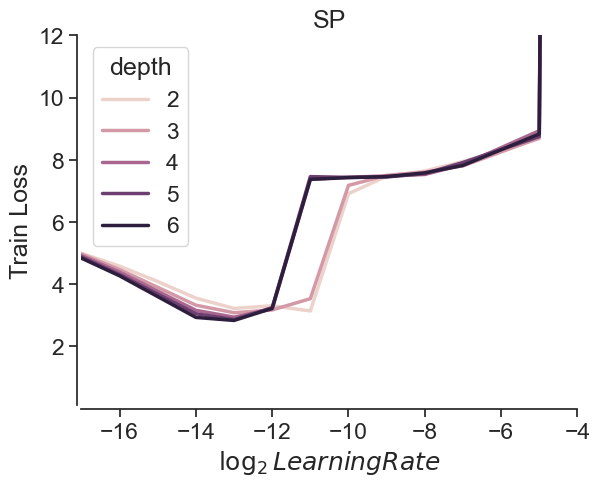

In [241]:
# Remove NaN results
transformer_runs_df['config.optimization.lr_log2'] = np.log2(transformer_runs_df['config.optimization.lr'])
runs_filtered = transformer_runs_df[transformer_runs_df['summary.train.loss'] != 'NaN']
ax = sns.lineplot(data=runs_filtered, x='config.optimization.lr_log2', y='summary.train.loss', hue='config.transformer_config.nlayers', legend="full")
ax.set_ylim(1e-1, 12)
ax.set_xlim(-17, -4)
ax.legend_.set_title('depth')
ax.set(xlabel="$\log_2LearningRate$", ylabel="Train Loss", title='SP')
sns.despine(ax=ax, offset=3)
fig = ax.get_figure()
fig.savefig("transformer_mup_train_depth.png" ,bbox_inches='tight')